### I. Commentaire de l'article "The Cointegration Alpha: Enhanced Index Tracking and Long-Short Equity Market Neutral Strategies"

Cet article propose différentes applications de stratégies d'investissement basées sur la cointégration, on note : 

- une stratégie classique de suivi d'indices;
- une stratégie d'actions long-short market neutral;
- une combinaison des deux approches précédentes.

L'idée de la première stratégie est de reproduire les rendements et la volatilité d'un indice de référence spécifique (exemple du CAC40), c'est-à-dire un portefeuille ayant de propriétés similaires à celui de l'indice en termes de rendements, volatilité et corrélation; tandis que les deux stratégies suivantes visent à minimiser la volatilité et générer des rendements stables quelles que soient les conditions de marché.

L'avantage de se baser sur la cointégration pour l'optimisation de portefeuille est qu'elle permet d'utiliser toutes les informations comprises dans les prix et de construire des poids sur le comportement long terme des actions.

One of the advantages of estimating the portfolio weights based on cointegration coefficients is their
enhanced stability. Being constructed on a rather long history of prices, they tend to ignore short-term
movements in stock prices, such as bubbles or just noise, and focus on the long-run behaviour of the
prices. 

The main point of our analysis was to show that, when applied to constructing trading strategies, the
cointegration technique produces encouraging results. Its key characteristics, i.e. mean reverting
tracking error, enhanced weights stability and better use of the information contained in stock prices,
allow a flexible design of various trading strategies, from index tracking to long-short market neutral.

## II. Expériences numériques transposées au marché français.

### 0. Data 

On pré-processe ici les données du CAC40 de 2001 à nos jours. Pour certaines valeurs, les données sont manquantes à partir d'un certain rang, on les complète naïvement par la dernière valeur présente dans cette colonne.

In [1]:
import pandas as pd
import numpy as np
from utils_long_short import calculer_rendement_iteratif, perform_regression, rebalance_and_evaluate, calculate_annual_global_metrics
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [2]:
file_path = '../data/CAC.xlsx'
sheet_name_weights = 'Worksheet'
sheet_name_data = 'Data'

df_weights = pd.read_excel(file_path, sheet_name=sheet_name_weights, index_col=0)
dict_weights_CAC = df_weights['Poids'].to_dict()

df_data = pd.read_excel(file_path, sheet_name=sheet_name_data, index_col=0)
df_data = df_data.fillna(method='ffill')

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_20653/1987031244.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_data = df_data.fillna(method='ffill')


In [3]:
dict_weights_CAC

{'AI FP Equity': 0.0534,
 'AIR FP Equity': 0.0476,
 'ALO FP Equity': 0.0022,
 'MT NA Equity': 0.0077,
 'CS FP Equity': 0.0327,
 'BNP FP Equity': 0.0426,
 'EN FP Equity': 0.0038,
 'CAP FP Equity': 0.0182,
 'CA FP Equity': 0.0055,
 'SGO FP Equity': 0.0178,
 'ML FP Equity': 0.0133,
 'ACA FP Equity': 0.0079,
 'BN FP Equity': 0.0217,
 'DSY FP Equity': 0.0173,
 'EDEN FP Equity': 0.0078,
 'ENGI FP Equity': 0.017,
 'EL FP Equity': 0.0332,
 'ERF FP Equity': 0.0043,
 'RMS FP Equity': 0.0352,
 'KER FP Equity': 0.0173,
 'OR FP Equity': 0.0619,
 'LR FP Equity': 0.0146,
 'MC FP Equity': 0.1064,
 'ORA FP Equity': 0.0111,
 'RI FP Equity': 0.019,
 'PUB FP Equity': 0.0112,
 'RNO FP Equity': 0.0045,
 'SAF FP Equity': 0.0335,
 'SAN FP Equity': 0.0585,
 'SU FP Equity': 0.0601,
 'GLE FP Equity': 0.0104,
 'STLAP FP Equity': 0.029,
 'STMPA FP Equity': 0.0168,
 'TEP FP Equity': 0.0046,
 'HO FP Equity': 0.0081,
 'TTE FP Equity': 0.09,
 'URW FP Equity': 0.0046,
 'VIE FP Equity': 0.0101,
 'DG FP Equity': 0.0351,


In [4]:
df_data.columns

Index(['CAC Index', 'OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity', 'DSY FP Equity', 'AI FP Equity', 'ERF FP Equity',
       'CS FP Equity', 'BNP FP Equity', 'BN FP Equity', 'SGO FP Equity',
       'MC FP Equity', 'EDEN FP Equity', 'ML FP Equity', 'KER FP Equity',
       'PUB FP Equity', 'RNO FP Equity', 'SAF FP Equity', 'HO FP Equity',
       'TEP FP Equity', 'RMS FP Equity', 'ENGI FP Equity', 'ORA FP Equity',
       'MT NA Equity', 'EN FP Equity', 'ALO FP Equity', 'VIE FP Equity',
       'SAN FP Equity', 'GLE FP Equity', 'SU FP Equity', 'AIR FP Equity',
       'URW FP Equity', 'LR FP Equity', 'ACA FP Equity', 'RI FP Equity',
       'STMPA FP Equity'],
      dtype='object')

In [76]:
df_data['SAF FP Equity']

Date
2001-01-02     24.6514
2001-01-03     23.3143
2001-01-04     24.1886
2001-01-05     23.6229
2001-01-08     23.6743
                ...   
2024-02-22    191.4400
2024-02-23    193.0200
2024-02-26    193.6600
2024-02-27    192.3200
2024-02-28    193.2200
Name: SAF FP Equity, Length: 5929, dtype: float64

# Long short Market neutral strategy 

On ajoute au benchmark en rendement supplémentaire de x% distrbué uniformément sur les jours. On va prendre x valant 5%, 10% et 15%. On le retire et on l'ajoute pour contruire un 'index_plus' et un 'index_minus'. 

### Création d'un index_plus et d'un index_minus

La fonction calculer rendement iteratif permet de d'ajouter un pourcentage au rendement du cac40. 

In [3]:
data = df_data[['CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity','STMPA FP Equity','ML FP Equity','ALO FP Equity','CS FP Equity','SAF FP Equity']] #on choisit de travailler sur uniquement quelques valeurs  
#'CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
 #      'TTE FP Equity'

In [4]:
df_plus_5_5y = calculer_rendement_iteratif(data, '2008-01-03', 5) #dataframe, date_depart, augmentation par an en pourcentage
df_min_5_5y = calculer_rendement_iteratif(data, '2008-01-03', -5)


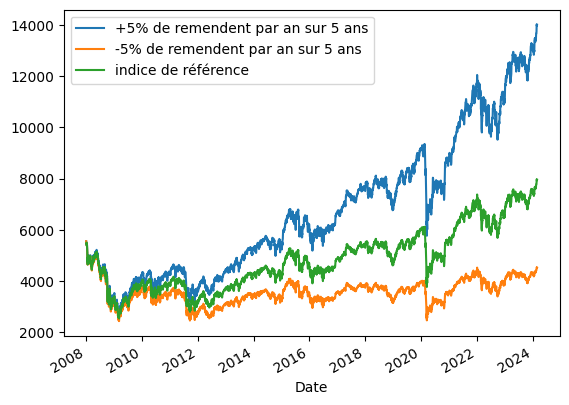

In [5]:
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")
df_data.loc["2008-01-05 ":]["CAC Index"].plot(label="indice de référence")
plt.legend()
plt.show() 

La nouvelle cointegration décrite dans l'article s'écrit de la manière suivante:

In [6]:
params_plus_intercept, params_plus, residuals_plus = perform_regression(df_plus_5_5y)
params_moins_intercept, params_moins, residuals_moins = perform_regression(df_min_5_5y)
print('les paramètres fit sont pour l\'index_plus: \n',params_plus)

print('les paramètres fit sont pour l\'index_moins: \n',params_moins)



les paramètres fit sont pour l'index_plus: 
 ACA FP Equity     -0.037658
OR FP Equity       0.418948
DG FP Equity       0.104534
STLAP FP Equity    1.448549
TTE FP Equity      0.250117
STMPA FP Equity    0.092965
ML FP Equity       0.029809
ALO FP Equity     -0.000574
CS FP Equity       0.187933
SAF FP Equity     -0.040731
dtype: float64
les paramètres fit sont pour l'index_moins: 
 ACA FP Equity     -0.090791
OR FP Equity       0.143652
DG FP Equity      -0.111101
STLAP FP Equity    1.781803
TTE FP Equity      0.306298
STMPA FP Equity    0.021701
ML FP Equity       0.150037
ALO FP Equity      0.106189
CS FP Equity       0.324407
SAF FP Equity     -0.142672
dtype: float64


### Backtest de la stratégie. 
On va ici ré-éstimer tous les 10 jours nos poids sur la période [date départ, date précédente+10]. On va à chaque fois que l'on rebalance nos poids s'assurer que le test ADF est correct, i.e. que la cointégration fonctionne proprement, et nous allons plotter ce graphique. On va aussi calculer le prix que l'on obtient en soustrayant les couts. Cela nous permettra d'avoir un rendement en temps réel de notre stratégie, vs un rendement de l'indice. Le fait d'avoir le prix en continu devrait nous permettre aussi d'avoir la volatilité, la possibilité de calculer la skewness et la kurtosis, ainsi que les sharpe ratio. 

In [7]:
adf_critic_value, adf_stats_list,replication_max,replication_min = rebalance_and_evaluate(df_plus_5_5y,df_min_5_5y,'2008-01-03',1)


/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_short.py:138: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio = pd.concat([portfolio, portfolio_price_plus-portfolio_price_minus])
/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_short.py:139: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  replication_max = pd.concat([replication_max, portfolio_price_plus])
/Users/adriencortes/Documents/3- Cours /7- EK/allocation actifs/Allocation-actifs/src/utils_long_s

On peut plot le test ADF pour vérifier de la cohérence de nos résultats. 

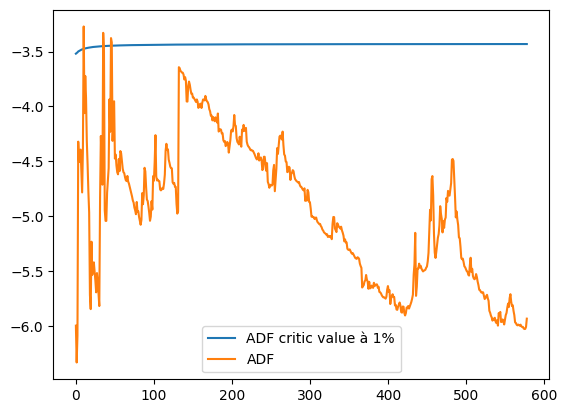

In [8]:
plt.plot(adf_critic_value[10:],label="ADF critic value à 1%")
plt.plot(adf_stats_list[10:],label = "ADF")
plt.legend()

On peut vérifier ci-dessous que l'on réplique bien les indices de hausses et de baisse. 

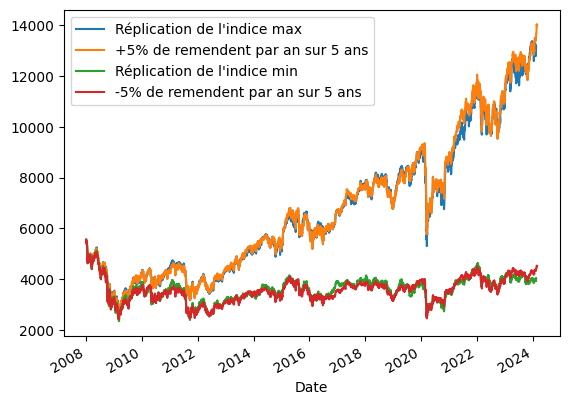

In [9]:
plt.plot(replication_max,label="Réplication de l'indice max")
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")

plt.plot(replication_min,label="Réplication de l'indice min")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")

plt.legend()
plt.show() 

On a donc mis en place une stratégie qui permet de répliquer les indices longs et courts. Il suffit maintenant de regarder la différence des rendements annuels des deux stratégies. Cela nous donnera le rendement de notre stratégie finale, nous allons pouvoir regarder ces rendements en fonction du temps, le sharpe ratio, la skewness et la kurtosis. 

In [10]:
annual_metrics = calculate_annual_global_metrics(replication_max, replication_min)
annual_metrics 

,Annual Global Return,Daily mean Return,Daily Variance of Global Return
2008,0.059386,0.000209,0.000004
2009,0.029356,0.000108,0.000011
2010,0.102911,0.000354,0.000016
2011,0.053846,0.000194,0.000017
2012,0.047696,0.000174,0.000018
2013,0.099427,0.000342,0.000008
2014,0.020007,0.000076,0.000009
2015,0.113258,0.000389,0.000015
2016,0.011286,0.000048,0.000016
2017,0.115438,0.000396,0.000014


La skew est : 1.0641330665752722  le ratio de sharpe :  1.305848313826538  et le kurtosis 2.50891378484757


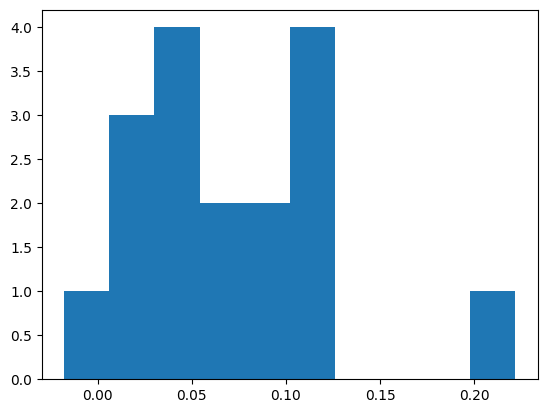

In [13]:
plt.hist(annual_metrics["Annual Global Return"])

ratio_sharpe = annual_metrics["Annual Global Return"].mean()/np.sqrt(annual_metrics["Annual Global Return"].var()) #le ratio de sharpe final
skew = annual_metrics["Annual Global Return"].skew()
kurtosis = annual_metrics["Annual Global Return"].kurtosis()

print("La skew est :",skew," le ratio de sharpe : ",ratio_sharpe," et le kurtosis",kurtosis ) #pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul
#on n'a pas repris un taux repo pour le ratio de sharpe. 

Il peut être intéressant aussi de regarder la corrélation des rendements avec les rendements de l'indice. 

In [14]:
annual_metrics["Annual Global Return"]

2008    0.059386
2009    0.029356
2010    0.102911
2011    0.053846
2012    0.047696
2013    0.099427
2014    0.020007
2015    0.113258
2016    0.011286
2017    0.115438
2018    0.103862
2019    0.096240
2020    0.063724
2021    0.047589
2022    0.047367
2023    0.221809
2024   -0.017796
Name: Annual Global Return, dtype: float64

In [22]:
daily_return_indice = df_data["CAC Index"].loc['2008-01-01':].pct_change().dropna()
daily_return_indice = daily_return_indice.groupby(daily_return_indice.index.year)
daily_return_indice.apply(lambda x: (1 + x).prod() - 1)

Date
2008   -0.420223
2009    0.223234
2010   -0.033419
2011   -0.169516
2012    0.152307
2013    0.179859
2014   -0.005400
2015    0.085264
2016    0.048576
2017    0.092600
2018   -0.109527
2019    0.263676
2020   -0.071369
2021    0.288507
2022   -0.094963
2023    0.165193
2024    0.054514
Name: CAC Index, dtype: float64

Les rendements sont peu corrélés avec ceux de l'indice. Seulement de 14%. 

In [23]:
np.corrcoef(annual_metrics["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)) #finalement les rendements annuels ne sont pas corrélés 

array([[1.        , 0.14578627],
       [0.14578627, 1.        ]])

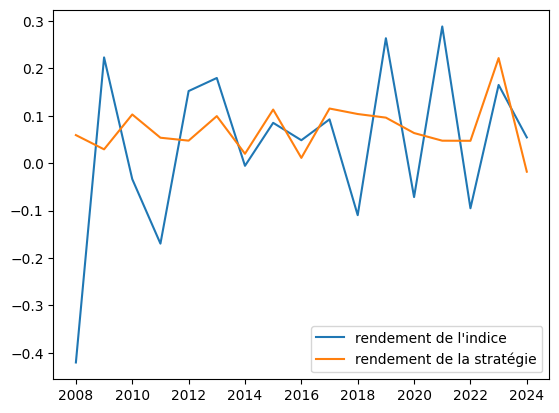

In [29]:
plt.plot(daily_return_indice.apply(lambda x: (1 + x).prod() - 1),label="rendement de l'indice")
plt.plot(annual_metrics["Annual Global Return"],label="rendement de la stratégie")
plt.legend()
plt.show()